In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
corpus_df = pd.read_csv("../incomplete_corpus_data/PotsdamSearchCorpus.dat", sep = "\t")
#testing with raw data from participant 1
raw_data = pd.read_csv("../incomplete_corpus_data/asc\SFC1_2.dat", sep = "\t", 
                       header = None, names=['time', 'x', 'y', 'pupil'])

In [3]:
#then I have to filter in corpus_df which data is for participant 1, but later I should optimize
#such that I import data and read from the corpus for all participants
corpus_p1 = corpus_df[corpus_df.subject == 1]

In [4]:
#USE THIS TO WRITE DATA IN ANOTHER FILES
"""
output_df = pd.DataFrame({'column_name': column_values})  
output_df.to_csv('output_file_name.dat')
"""

"\noutput_df = pd.DataFrame({'column_name': column_values})  \noutput_df.to_csv('output_file_name.dat')\n"

In [5]:
#CHECK IF RICHARD WANTS EVERYTHING IN A TIME SEQUENCE - PROBABLY YES, THEN ADJUST TIMES FOR IT

def get_valid_times(raw_data, corpus_data):
    """
    get all valid time stamps, i.e, filter the times such 
    that all times in the raw data are in between the imagestart and imageend times
    in the corpus_data.
    Here corpus_data corresponds to the data already filtered by participant number to match 
    the participant number from the raw_data file.
    :param raw_data: pandas data frame with columns = =['time', 'x', 'y', 'pupil']
    :param corpus_data: pandas data frame filtered for participant number #n
    
    :return: raw_data with only valid time stamps
    """
    
    n_trials = corpus_data['trialno'].iloc[-1] #get number of trials
    intervals = np.zeros((n_trials,2))
    for trial in range(n_trials):
        intervals[trial,0]=corpus_data[corpus_data['trialno']==trial+1]["imagestart"].iloc[0]
        intervals[trial,1]=corpus_data[corpus_data['trialno']==trial+1]["imageend"].iloc[0]
        
    ##subtract time zero 
    time_zero = corpus_data["imagestart"].iloc[0]
    raw_data['time'] -= time_zero
    raw_data = raw_data.drop(raw_data[raw_data.time < 0].index)
    raw_data['time'] += time_zero
    
    for trial in range(1,n_trials):
        end_last = intervals[trial-1,1] #end of the last trial
        beg_curr = intervals[trial,0] #beggining of the current trial
        raw_data = raw_data.drop(raw_data[(raw_data.time > end_last) & (raw_data.time < beg_curr)].index)

    raw_data = raw_data.drop(raw_data[(raw_data.time > intervals[-1,1])].index)

    return raw_data, intervals

In [6]:
filtered_raw, intervals = get_valid_times(raw_data, corpus_p1)
time_size = len(filtered_raw.time)
filtered_raw.insert(4,"newtime",np.arange(time_size,dtype=int))

In [7]:
def associate_image_number(filtered_raw, intervals, corpus_data):
    """
    Associate each time stamp in the filtered raw data to the image number, according to
    the corpus data. 
    
    :param filtered_raw: pandas data frame with columns = =['time', 'x', 'y', 'pupil'] after
    filtering for the valid times with the function get_valid_times
    :param intervals: numpy array n_trials x 2, intervals of valid times for each trial
    :param corpus data: pandas data frame filtered for participant number #n
    
    :return: filtered_raw with one more column, 'imageno', trial durations in numpy array length 
    n_trials, each entry is the number of time stamps that correspond to one trial
    """
    #associate image number (imageno) to the appropriate trial condition
    n_trials = intervals.shape[0]
    trial_durations = np.zeros(n_trials, dtype = int)
    raw_imagenos = []
    for trial in range(n_trials):
        im=corpus_data[corpus_data['trialno']==trial+1]["imageno"].iloc[0] 
        trial_durations[trial]=len(filtered_raw[(filtered_raw.time >= intervals[trial][0]) & 
                 (filtered_raw.time <= intervals[trial][1])])
        temp = im*np.ones([trial_durations[trial]])
        raw_imagenos.extend(temp)
    filtered_raw.insert(5,"imageno",np.asarray(raw_imagenos,dtype=int))
    return filtered_raw, trial_durations, raw_imagenos    

In [8]:
filtered_raw, trial_durations, raw_imagenos = associate_image_number(filtered_raw, intervals, corpus_p1)

In [9]:
def add_is_saccade(filtered_raw, intervals, corpus_data):
    """
    By comparing time stamps with the corpus_data, we get which time stamps corresponds 
    to saccades (=1) and which dont (=0). 
    
    :param filtered_raw: pandas data frame with columns = =['time', 'x', 'y', 'pupil','imageno']
    :param intervals: numpy array n_trials x 2, intervals of valid times for each trial
    :param corpus data: pandas data frame filtered for participant number #n
    
    :return: filtered_raw with one more column, 'is_saccade', that is composed by zeros and ones, 
    where zero correspond to fixation and a one correspond to a saccade
    """
    is_saccade = np.ones(len(filtered_raw.time),dtype = int)
    n_trials = len(intervals)
    #search_times = []
    curr_pos = 0
    
    for trial in range(n_trials):
        n_fix = corpus_data[corpus_data.trialno==trial+1].fixno
        beg_trial = intervals[trial][0]
        end_trial = intervals[trial][1]
        curr_pos = corpus_data[corpus_data.trialno==trial+1].imagestart.iloc[0]
        
        for fix in n_fix:
            temp_fix = corpus_data[(corpus_data.trialno == trial+1) & (corpus_data.fixno ==fix)]
            temp_fix_onset = int(temp_fix.fixonset+curr_pos-1)
            temp_fix_offset = int(temp_fix.fixoffset+curr_pos-1)
            idx_new_time_onset = np.where(filtered_raw.time == temp_fix_onset)[0][0]
            idx_new_time_offset = np.where(filtered_raw.time == temp_fix_offset)[0][0]
            is_saccade[idx_new_time_onset:idx_new_time_offset] = 0
  
    filtered_raw.insert(6,"is_saccade",is_saccade)
    #filtered_raw.insert(7,"fixno",fixno)
    
    return filtered_raw
    

In [10]:
filtered_raw = add_is_saccade(filtered_raw, intervals, corpus_p1) 

In [11]:
random_im = np.random.choice(np.unique(filtered_raw.imageno),6)
x_is = filtered_raw[(filtered_raw.is_saccade > 0) & (filtered_raw.imageno == 2)]["x"]
y_is = filtered_raw[(filtered_raw.is_saccade > 0) & (filtered_raw.imageno == 2)]["y"]
x_not = filtered_raw[(filtered_raw.is_saccade == 0) & (filtered_raw.imageno == 2)]["x"]
y_not = filtered_raw[(filtered_raw.is_saccade == 0) & (filtered_raw.imageno == 2)]["y"]

In [12]:
random_im

array([  1,  67,  42,  17,  91, 101])

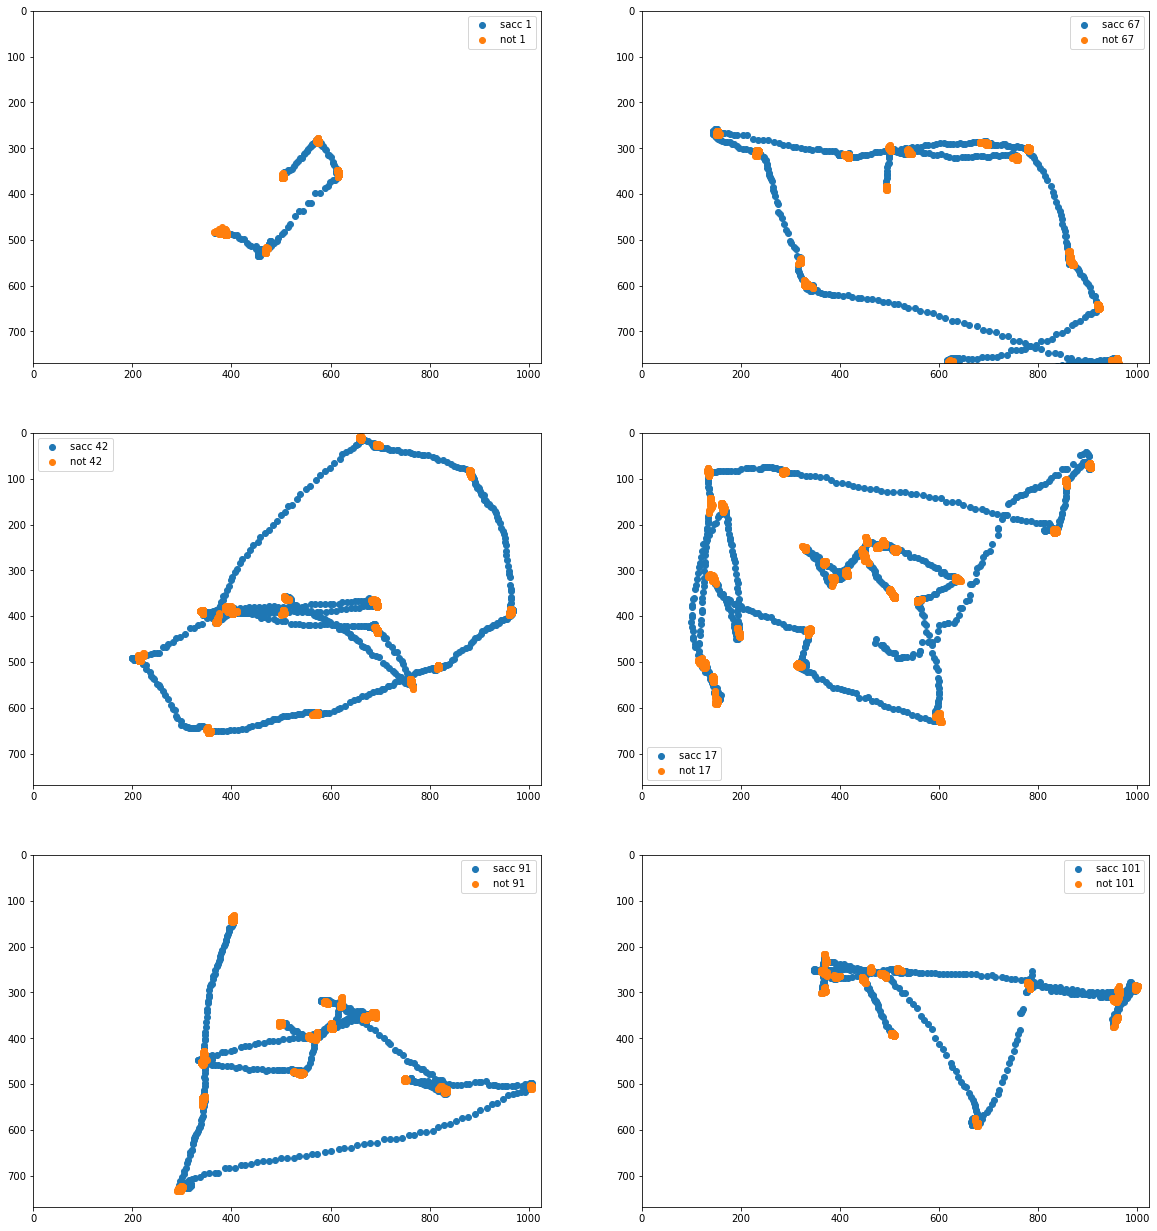

In [13]:
fig, ax = plt.subplots(3,2, figsize = (20,22))
count = 0
for i in range(3):
    for j in range(2):
        im = random_im[count]
        x_is = filtered_raw[(filtered_raw.is_saccade > 0) & (filtered_raw.imageno == im)]["x"]
        y_is = filtered_raw[(filtered_raw.is_saccade > 0) & (filtered_raw.imageno == im)]["y"]
        x_not = filtered_raw[(filtered_raw.is_saccade == 0) & (filtered_raw.imageno == im)]["x"]
        y_not = filtered_raw[(filtered_raw.is_saccade == 0) & (filtered_raw.imageno == im)]["y"]

        ax[i,j].scatter(x_is,y_is, label='sacc {}'.format(im))
        ax[i,j].scatter(x_not, y_not,label='not {}'.format(im))
        ax[i,j].set_xlim([0, 1024])
        ax[i,j].set_ylim([0, 768])
        ax[i,j].invert_yaxis()
        ax[i,j].legend()

        count += 1

plt.savefig("trajectories.png")

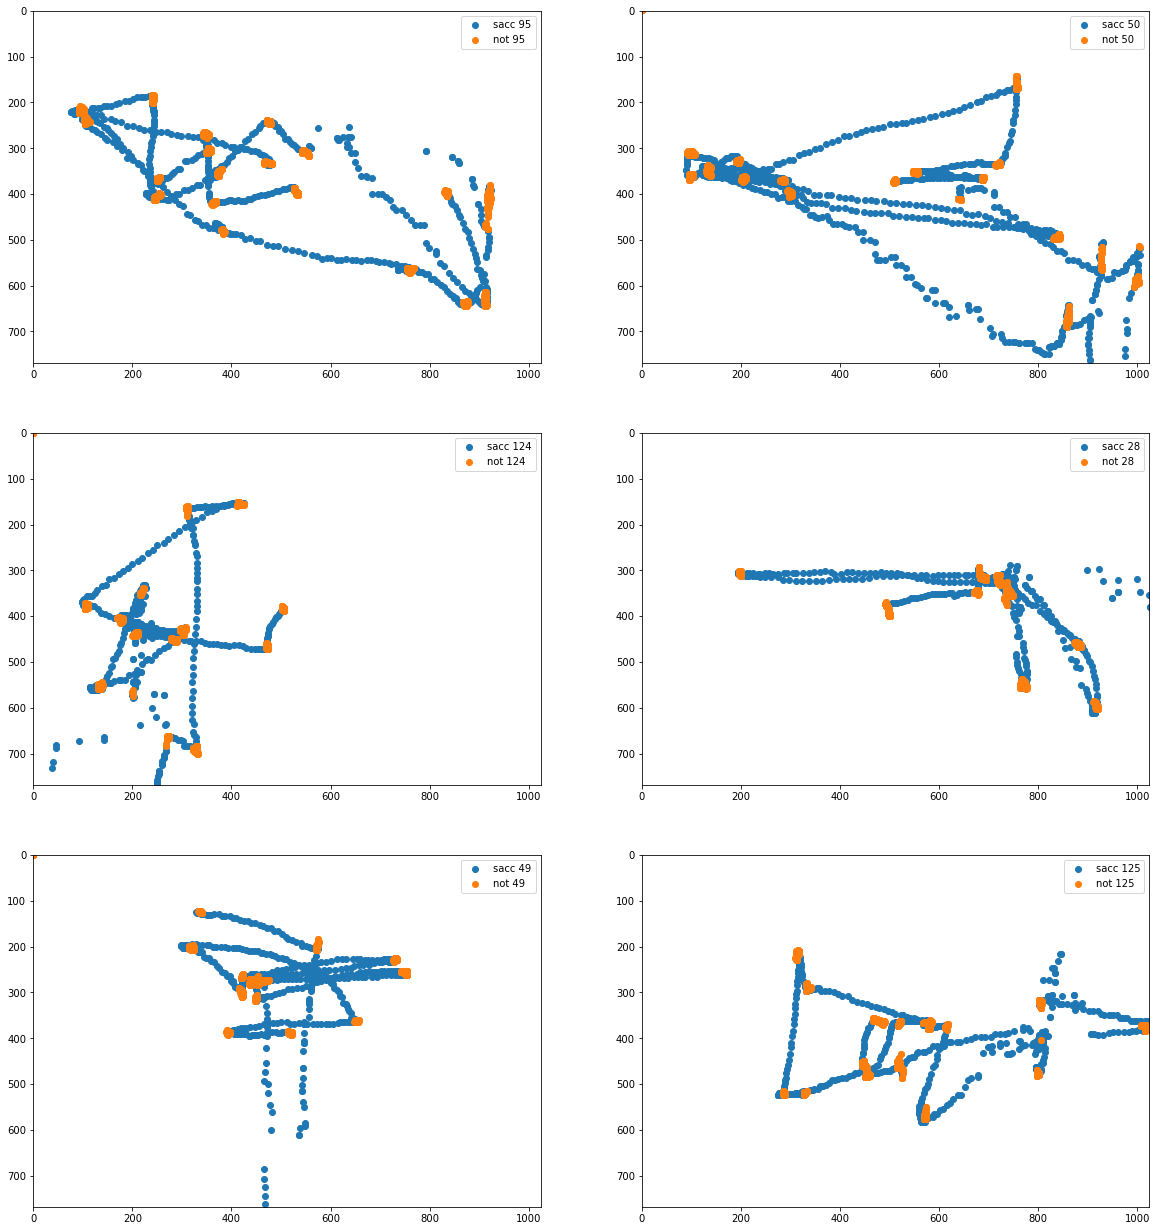

In [14]:
noisy_im = np.array([95,50,124,28,49,125])
fig, ax = plt.subplots(3,2, figsize = (20,22))
count = 0
for i in range(3):
    for j in range(2):
        im = noisy_im[count]
        x_is = filtered_raw[(filtered_raw.is_saccade > 0) & (filtered_raw.imageno == im)]["x"]
        y_is = filtered_raw[(filtered_raw.is_saccade > 0) & (filtered_raw.imageno == im)]["y"]
        x_not = filtered_raw[(filtered_raw.is_saccade == 0) & (filtered_raw.imageno == im)]["x"]
        y_not = filtered_raw[(filtered_raw.is_saccade == 0) & (filtered_raw.imageno == im)]["y"]

        ax[i,j].scatter(x_is,y_is, label='sacc {}'.format(im))
        ax[i,j].scatter(x_not, y_not,label='not {}'.format(im))
        ax[i,j].set_xlim([0, 1024])
        ax[i,j].set_ylim([0, 768])
        ax[i,j].invert_yaxis()
        ax[i,j].legend()

        count += 1

plt.savefig("trajectories_noisy.png")

In [15]:
#omit trials with fixations outside the screen, take an extra margin outside the screen and then 
#exclude the trial

In [16]:
filtered_raw

,time,x,y,pupil,newtime,imageno,is_saccade
43873,4239225,511.7,372.9,6802.0,0,50,0
43874,4239226,511.7,372.9,6802.0,1,50,0
43875,4239227,511.8,372.3,6804.0,2,50,0
43876,4239228,511.7,372.3,6804.0,3,50,0
43877,4239229,511.7,372.3,6804.0,4,50,0
...,...,...,...,...,...,...,...
1115751,6234829,350.7,457.7,8635.0,493526,62,0
1115752,6234830,350.6,457.7,8635.0,493527,62,0
1115753,6234831,350.6,457.7,8637.0,493528,62,0
1115754,6234832,350.7,456.2,8638.0,493529,62,1


In [17]:
#have the fixations and saccades numbers, and then exclude time column 

In [18]:
# add those 4 columns
#filtertype	filterregion	targetpresent	expectedlocation
#raileigh test, for non uniformity

In [23]:
trial = 0
n_fix = corpus_p1[corpus_p1.trialno==1].fixno


beg_trial = intervals[trial][0]
end_trial = intervals[trial][1]
curr_pos = corpus_p1[corpus_p1.trialno==trial+1].imagestart.iloc[0]
        

In [24]:
beg_trial

4239225.0

In [25]:
end_trial

4245052.0

In [26]:
curr_pos

4239225